<a href="https://colab.research.google.com/github/githma2000/liver-tumor-segmentation/blob/main/tumor%20segmentation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import os

DATASET_PATH = '/content/drive/MyDrive/Preprocessed_3Dircadb'


In [9]:
import os
import random
import shutil

base_dir = '/content/drive/MyDrive/Preprocessed_3Dircadb'
all_patients = sorted([f for f in os.listdir(base_dir) if f.startswith('3Dircadb')])

# Shuffle and split
random.seed(42)
random.shuffle(all_patients)

train_split = int(0.7 * len(all_patients))
val_split = int(0.85 * len(all_patients))

train_patients = all_patients[:train_split]
val_patients = all_patients[train_split:val_split]
test_patients = all_patients[val_split:]

print("Train:", train_patients)
print("Val:", val_patients)
print("Test:", test_patients)


Train: ['3Dircadb1.9', '3Dircadb1.14', '3Dircadb1.4', '3Dircadb1.13', '3Dircadb1.18', '3Dircadb1.3', '3Dircadb1.5', '3Dircadb1.8', '3Dircadb1.15', '3Dircadb1.20', '3Dircadb1.7', '3Dircadb1.19', '3Dircadb1.10', '3Dircadb1.2']
Val: ['3Dircadb1.11', '3Dircadb1.6', '3Dircadb1.16']
Test: ['3Dircadb1.17', '3Dircadb1.1', '3Dircadb1.12']


In [10]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import random

class IRCADNPYDataset(Sequence):
    def __init__(self, patient_list, base_path, batch_size=8, input_size=(256, 256), shuffle=True):
        self.patient_list = patient_list
        self.base_path = base_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.data = self._load_all_files()
        self.on_epoch_end()

    def _load_all_files(self):
        data_pairs = []
        for patient in self.patient_list:
            img_dir = os.path.join(self.base_path, patient, 'PATIENT_2_5D')
            mask_dir = os.path.join(self.base_path, patient, 'LABEL_2_5D')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    data_pairs.append((img_path, mask_path))
        return data_pairs

    def __len__(self):
        return max(1, len(self.data) // self.batch_size)

    def __getitem__(self, idx):
        batch_pairs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_path, mask_path in batch_pairs:

            img = np.load(img_path)
            img = img.astype(np.float32)

            mask = np.load(mask_path)
            mask = mask.astype(np.float32)


            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            elif mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0:1]


            min_val = np.min(mask)
            max_val = np.max(mask)


            threshold = min_val + (max_val - min_val) * 0.1


            mask = (mask > threshold).astype(np.float32)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def ASPP(x, filters):
    """Atrous Spatial Pyramid Pooling with Keras-compatible operations"""
    shape = x.shape

    y1 = Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, 3, padding="same", dilation_rate=6, use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, 3, padding="same", dilation_rate=12, use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, 3, padding="same", dilation_rate=18, use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # Use GlobalAveragePooling2D and reshape for broadcast
    y5 = tf.keras.layers.GlobalAveragePooling2D()(x)
    y5 = tf.keras.layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = Conv2D(filters, 1, padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = concatenate([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    """Custom DeepLabV3+ model with ResNet50 backbone"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use features from different levels of the encoder
    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x = ASPP(image_features, 256)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = base_model.get_layer("conv2_block3_2_relu").output
    low_level_feat = Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation("relu")(low_level_feat)

    x = concatenate([x, low_level_feat])
    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

def compute_distance_map(seg):
    seg = seg.cpu().numpy()
    dist_map = []
    for s in seg:
        posmask = s.astype(bool)
        negmask = ~posmask
        posdist = distance_transform_edt(negmask)
        negdist = distance_transform_edt(posmask)
        dist = posdist - negdist
        dist_map.append(dist)
    return torch.tensor(dist_map).float().to(seg.device)

class DistanceMapLoss(nn.Module):
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()
        dist_map = compute_distance_map(target)
        return (pred * dist_map).mean()

class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.dice = DiceLoss()
        self.boundary = DistanceMapLoss()

    def forward(self, pred, target):
        return self.dice(pred, target) + self.boundary(pred, target)

# Initialize the loss
criterion = CompositeLoss()


In [13]:
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)

# UNFREEZE all layers of the model, including ResNet50 layers
for layer in model.layers:
    layer.trainable = True  # Make everything trainable (including ResNet50)

def bce_dice_loss(y_true, y_pred):
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Dice
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)

    # Binary Cross-Entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Combine
    return 1 - dice + bce

def iou_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=bce_dice_loss,
    metrics=[iou_metric]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_dataset = IRCADNPYDataset(train_patients, base_dir, batch_size=8)
val_dataset = IRCADNPYDataset(val_patients, base_dir, batch_size=8)
test_dataset = IRCADNPYDataset(test_patients, base_dir, batch_size=8)

# EarlyStopping: watch validation IoU
early_stop = EarlyStopping(
    monitor='val_iou_metric',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# ModelCheckpoint: save best model based on IoU
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model.keras',
    monitor='val_iou_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - iou_metric: 0.2187 - loss: 1.1950 
Epoch 1: val_iou_metric improved from -inf to 0.07562, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 3127s 13s/step - iou_metric: 0.2191 - loss: 1.1939 - val_iou_metric: 0.0756 - val_loss: 2.0945
Epoch 2/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - iou_metric: 0.4684 - loss: 0.5301
Epoch 2: val_iou_metric improved from 0.07562 to 0.12560, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 72s 307ms/step - iou_metric: 0.4686 - loss: 0.5299 - val_iou_metric: 0.1256 - val_loss: 1.0903
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - iou_metric: 0.5816 - loss: 0.3865
Epoch 3: val_iou_metric improved from 0.12560 to 0.34247, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 73s 314ms/step - iou_metric: 0.5816 - loss: 0.3865 - val_iou_metric: 0.3425 - val_loss: 0.7

In [15]:
from scipy.ndimage import binary_erosion

def get_surface(mask):
    eroded = binary_erosion(mask)
    surface = mask ^ eroded  # XOR: Surface pixels only
    return surface


In [16]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum())

def voe(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1 - (intersection / union)

def rvd(pred, gt):
    return (pred.sum() - gt.sum()) / gt.sum()
def assd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return surface_distances.mean()

def rmsd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return np.sqrt((surface_distances ** 2).mean())


# Example usage
# pred_mask and gt_mask should be binary (0 and 1) masks

# Example dummy masks (replace with your real predictions)
pred_mask = np.random.randint(0, 2, (256, 256))
gt_mask = np.random.randint(0, 2, (256, 256))

dice = dice_coefficient(pred_mask, gt_mask)
voe_score = voe(pred_mask, gt_mask)
rvd_score = rvd(pred_mask, gt_mask)
assd_score = assd(pred_mask, gt_mask)
rmsd_score = rmsd(pred_mask, gt_mask)

print(f"Dice Coefficient: {dice:.4f}")
print(f"VOE: {voe_score:.4f}")
print(f"RVD: {rvd_score:.4f}")
print(f"ASSD: {assd_score:.4f}")
print(f"RMSD: {rmsd_score:.4f}")


Dice Coefficient: 0.5017
VOE: 0.6652
RVD: 0.0033
ASSD: 127.5323
RMSD: 147.3768


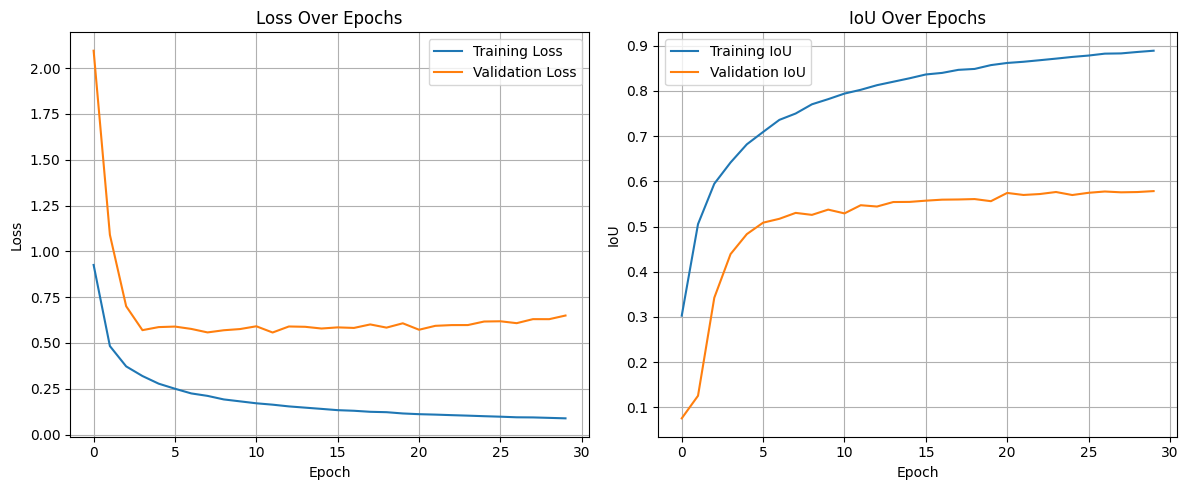

In [19]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
import numpy as np

def compute_confusion_elements(y_true, y_pred, threshold=0.5):
    """
    y_true: ground truth mask (numpy array or tensor), shape: (batch, H, W, 1)
    y_pred: predicted mask (before thresholding), shape: (batch, H, W, 1)
    threshold: probability threshold to binarize predictions
    """
    y_true = y_true.astype(np.bool_)
    y_pred = (y_pred >= threshold).astype(np.bool_)

    TP = np.logical_and(y_pred == 1, y_true == 1).sum()
    FP = np.logical_and(y_pred == 1, y_true == 0).sum()
    TN = np.logical_and(y_pred == 0, y_true == 0).sum()
    FN = np.logical_and(y_pred == 0, y_true == 1).sum()

    return TP, FP, TN, FN


In [21]:
# Predict on validation dataset (just one batch as example)
images, masks = next(iter(val_dataset))  # assuming val_dataset returns numpy arrays
preds = model.predict(images)

# Compute confusion matrix elements
TP, FP, TN, FN = compute_confusion_elements(masks, preds)

print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
TP: 37299, FP: 33466, TN: 447838, FN: 5685


In [22]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
iou = TP / (TP + FP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


Precision: 0.5271
Recall:    0.8677
F1 Score:  0.6558
IoU:       0.4879
Accuracy:  0.9253


In [23]:
import numpy as np
import cv2  # OpenCV is great for this task

def post_process_mask(mask, min_area=500):
    """
    Remove small connected components (blobs) from binary mask.

    Parameters:
        mask (np.array): Binary prediction mask (0 and 1)
        min_area (int): Minimum area (in pixels) to keep the component

    Returns:
        cleaned_mask (np.array): Binary mask with small blobs removed
    """
    mask = mask.astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    cleaned_mask = np.zeros_like(mask)

    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned_mask[labels == i] = 1

    return cleaned_mask


NameError: name 'input_image' is not defined